In [1]:
from gp import *
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
import importlib
import gp
importlib.reload(gp)
from gp import *
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Dataset characteristics<br>
- instant: record index<br>
- dteday : date
- season : season (1:springer, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month (1 to 12)
- hr : hour (0 to 23)
- holiday : whether day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit : 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

In [3]:
import pandas as pd

df = pd.read_csv("hour.csv")
df

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


# Data Preprocess

In [4]:
reference_date = pd.Timestamp('2011-01-01')
df.iloc[:, 1] = (pd.to_datetime(df.iloc[:, 1]) - reference_date).dt.days
data = df.to_numpy(dtype=float)
data

array([[1.0000e+00, 0.0000e+00, 1.0000e+00, ..., 3.0000e+00, 1.3000e+01,
        1.6000e+01],
       [2.0000e+00, 0.0000e+00, 1.0000e+00, ..., 8.0000e+00, 3.2000e+01,
        4.0000e+01],
       [3.0000e+00, 0.0000e+00, 1.0000e+00, ..., 5.0000e+00, 2.7000e+01,
        3.2000e+01],
       ...,
       [1.7377e+04, 7.3000e+02, 1.0000e+00, ..., 7.0000e+00, 8.3000e+01,
        9.0000e+01],
       [1.7378e+04, 7.3000e+02, 1.0000e+00, ..., 1.3000e+01, 4.8000e+01,
        6.1000e+01],
       [1.7379e+04, 7.3000e+02, 1.0000e+00, ..., 1.2000e+01, 3.7000e+01,
        4.9000e+01]])

In [5]:
X_whole = data[:, 1:14] # the first column is index, not necessary
Y_whole = data[:, 16] # count of total rental bikes as label
X_whole 

array([[0.000e+00, 1.000e+00, 0.000e+00, ..., 2.879e-01, 8.100e-01,
        0.000e+00],
       [0.000e+00, 1.000e+00, 0.000e+00, ..., 2.727e-01, 8.000e-01,
        0.000e+00],
       [0.000e+00, 1.000e+00, 0.000e+00, ..., 2.727e-01, 8.000e-01,
        0.000e+00],
       ...,
       [7.300e+02, 1.000e+00, 1.000e+00, ..., 2.576e-01, 6.000e-01,
        1.642e-01],
       [7.300e+02, 1.000e+00, 1.000e+00, ..., 2.727e-01, 5.600e-01,
        1.343e-01],
       [7.300e+02, 1.000e+00, 1.000e+00, ..., 2.727e-01, 6.500e-01,
        1.343e-01]])

In [6]:
def standardize(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    return (X-mean)/std, mean, std

def split_train_test(X_whole, Y_whole, num=1500, rate=0.7):
    # Shuffle data first
    indices = jax.random.permutation(grab_prng(), X_whole.shape[0])
    X_part = X_whole[indices]
    Y_part = Y_whole[indices]
    
    indices = jax.random.permutation(grab_prng(), num)
    X_shuffled = X_part[indices]
    Y_shuffled = Y_part[indices]
    
    # Standardize the shuffled data
    X, mean, std = standardize(X_shuffled)
    Y, mean, std = standardize(Y_shuffled)

    # Use the same indices for Y
    # Y = Y_shuffled
    
    # Compute the split index
    split_idx = int(num * rate)
    
    # Split indices into train and test
    train_indices = indices[:split_idx]
    test_indices = indices[split_idx:]
    
    # Split data using the indices
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    
    return X_train, Y_train, X_test, Y_test


In [7]:
def split_clml(X_train, Y_train, ratio=0.8):
    n_samples = X_train.shape[0]
    indices = jax.random.permutation(grab_prng(), n_samples)
    # Shuffle the data
    X_train_shuffled = X_train[indices]
    Y_train_shuffled = Y_train[indices]
    
    # Calculate the base size of each subset
    subset_size = int(n_samples * ratio)
    
    # Initialize lists to hold the subsets
    X_con = [X_train_shuffled[:subset_size], X_train_shuffled[subset_size:]]
    Y_con = [Y_train_shuffled[:subset_size], Y_train_shuffled[subset_size:]]
    
    return X_con, Y_con

def split_sequence(X_train, Y_train, seq_len=8):
    n_samples = X_train.shape[0]
    indices = jax.random.permutation(grab_prng(), n_samples)
     # Shuffle the data
    X_train_shuffled = X_train[indices]
    Y_train_shuffled = Y_train[indices]
    
    # Calculate the base size of each subset
    subset_size = n_samples // seq_len
    remainder = n_samples % seq_len
    
    # Initialize lists to hold the subsets
    X_seq = []
    Y_seq = []
    
    start_idx = 0
    for i in range(seq_len):
        # The first subset gets the remainder (extra) samples
        if i == 0:
            end_idx = start_idx + subset_size + remainder
        else:
            end_idx = start_idx + subset_size
        
        X_seq.append(X_train_shuffled[start_idx:end_idx])
        Y_seq.append(Y_train_shuffled[start_idx:end_idx])
        
        start_idx = end_idx
    return X_seq, Y_seq

In [8]:
X_train, Y_train, X_test, Y_test = split_train_test(X_whole, Y_whole, num=3000, rate=0.7)
X_con, Y_con = split_clml(X_train, Y_train, ratio=0.8)
X_seq, Y_seq = split_sequence(X_train, Y_train, seq_len=8)



# Hyperparameter initialization

Note that, in the below initialization, it is assumed that noise variance is the first component, signal variance the second, and length scale the third. Feel free to modify if using pytrees.

Further note: these are assumed constrained (strictly positive). You should map to unconstrained prior to running optimization, and map back to constrained when forming the GP posterior, and evaluating the predictive density for evaluation.

In [9]:
# def random_init_sqexp_hyperparams():
#     return np.array([jax.random.uniform(grab_prng(), minval=0.2, maxval=2),
#                      jax.random.uniform(grab_prng(), minval=0.2, maxval=2),
#                      X_train.shape[1]*jax.random.uniform(grab_prng(), minval=1, maxval=10)])
#

# Plotting code

In [10]:
def scatterplot(lml_lpd):
    plt.scatter(lml_lpd[:,0], lml_lpd[:,1])
    
    plt.xlabel('Log marginal likelihood')
    plt.ylabel('Negative log predictive density')
    plt.title('Is marginal likelihood a good indicator of generalization?')
    plt.legend()
#

# Experiment 1: Empirical Bayes for squared-exponential kernel

In [11]:
# n_trials = 20
# T = 200
# step_size = 5e-4

# gathered_trials = []
# hyperparams_inits = []
# for i in range(n_trials):
#    hyperparams_inits.append(random_init_sqexp_hyperparams())

# cov_func = sqexp_cov_function
# X_star = X_test
# for n in range(n_trials):
#    hyperparams_init = hyperparams_inits[n]
#    unconstrained_hyperparams_init = inverse_param_transform(hyperparams_init)
   
#    # sqexp_cov_function(X_train, X_train, unconstrained_hyperparams_init)
   
#    (unconstrained_hyperparams, lml) = empirical_bayes(cov_func, X_train, Y_train, unconstrained_hyperparams_init, step_size, T)
#    hyperparams = param_transform(unconstrained_hyperparams)
   
#    posterior_predictive = gp_posterior(cov_func, X_train, Y_train, hyperparams_init)
#    (posterior_mean, posterior_var) = posterior_predictive(X_star)
#    neg_log_initial = neg_log_predictive_density(Y_test, posterior_mean, posterior_var, hyperparams_init[0])

#    posterior_predictive = gp_posterior(cov_func, X_train, Y_train, hyperparams)
#    (posterior_mean, posterior_var) = posterior_predictive(X_star)
#    neg_log_final = neg_log_predictive_density(Y_test, posterior_mean, posterior_var, hyperparams[0])

#    print(np.array([neg_log_initial, neg_log_final, lml]))
#    gathered_trials.append(np.array([neg_log_initial, neg_log_final, lml]))
# #
# gathered_trials

In [12]:
# trials_array = np.array(gathered_trials)
# lml_lpd = np.column_stack((trials_array[:, 2], trials_array[:, 1]))
# scatterplot(lml_lpd)


# Dicsussion
1. Negative log probability was consistently improved over the hyperparameters used at initialization, across all runs.
2. According to the scatterplot above, we can see that as log marginal likelihood increases, negative log predicitive density on test set decreases at first, and increases later. Log marginal likelihood is a metric of our hyperparameters. The larger log marginal likelihood is, the better our hyperparameters are. But if they are better is determined by training set. Thus it's reasonable that "better" hyperparameters on training set don't always work better on test set. A large marginal likelihood may cause overfitting, although it works very well on training set. It's not a good indicator of generalization.

# Experiment 2 - feature importance using learned Mahalanobis distances

In [13]:
# use as your initial hyperparameters -> first two parameters are noise variance and signal variance,
# remaining parameters are length scale; feel free to modify if using pytrees
def random_init_sqexp_maha_hyperparams(X_train):
    var = jax.random.uniform(grab_prng(), shape=(2,), minval=0.2, maxval=2)
    length_scale = jax.random.uniform(grab_prng(), shape=(X_train.shape[1],), minval=1, maxval=10)
    return np.concatenate([var, length_scale])


In [14]:
# experiment settings
n_trials = 20

cov_func = sqexp_mahalanobis_cov_function
X_star = X_test
hyperparams_inits = []
for i in range(n_trials):
   hyperparams_inits.append(random_init_sqexp_maha_hyperparams(X_train))


In [ ]:
import importlib
import gp
importlib.reload(gp)
from gp import *
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# optimize hyperparameters according lml
lml_trials = []
T = 200
step_size = 1e-4
for n in range(n_trials):
   hyperparams_init = hyperparams_inits[n]
   unconstrained_hyperparams_init = inverse_param_transform(hyperparams_init)
   (unconstrained_hyperparams, lml) = empirical_bayes(cov_func, X_train, Y_train, unconstrained_hyperparams_init, step_size, T)
   hyperparams = param_transform(unconstrained_hyperparams)
   
   posterior_predictive = gp_posterior(cov_func, X_train, Y_train, hyperparams_init)
   (posterior_mean, posterior_var) = posterior_predictive(X_star)
   neg_log_initial = neg_log_predictive_density(Y_test, posterior_mean, posterior_var, hyperparams_init[0])

   posterior_predictive = gp_posterior(cov_func, X_train, Y_train, hyperparams)
   (posterior_mean, posterior_var) = posterior_predictive(X_star)
   neg_log_final = neg_log_predictive_density(Y_test, posterior_mean, posterior_var, hyperparams[0])
   print(np.array([neg_log_initial, neg_log_final, lml]))
   lml_trials.append(np.array([neg_log_initial, neg_log_final, lml]))
# #

[1053.82636063   50.07523785 1135.40995161]
[1143.69584877   73.45485445 1105.08390896]


C:\Users\Yue\AppData\Local\Temp\ipykernel_9632\1312685826.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


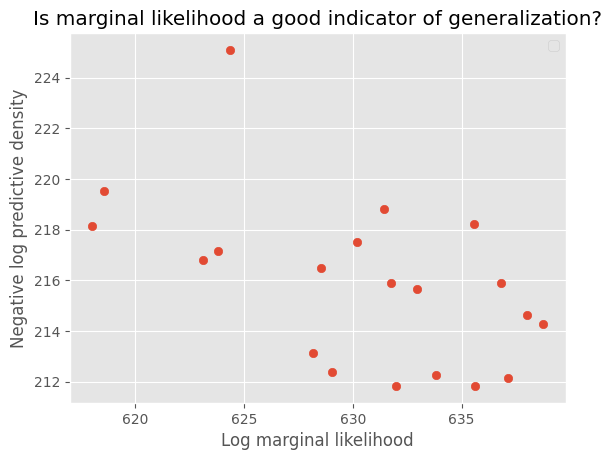

In [ ]:
trials_array = np.array(lml_trials)
lml_lpd = np.column_stack((trials_array[:, 2], trials_array[:, 1]))
scatterplot(lml_lpd)

In [ ]:
import importlib
import gp
importlib.reload(gp)
from gp import *
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# optimize hyperparameters according lml
clml_trials = []
T = 200
step_size = 1e-3
for n in range(n_trials):
   hyperparams_init = hyperparams_inits[n]
   unconstrained_hyperparams_init = inverse_param_transform(hyperparams_init)
   (unconstrained_hyperparams, clml) = clml_opt(cov_func, X_con, Y_con, unconstrained_hyperparams_init, step_size, T)
   hyperparams = param_transform(unconstrained_hyperparams)
   
   posterior_predictive = gp_posterior(cov_func, X_train, Y_train, hyperparams_init)
   (posterior_mean, posterior_var) = posterior_predictive(X_star)
   neg_log_initial = neg_log_predictive_density(Y_test, posterior_mean, posterior_var, hyperparams_init[0])

   posterior_predictive = gp_posterior(cov_func, X_train, Y_train, hyperparams)
   (posterior_mean, posterior_var) = posterior_predictive(X_star)
   neg_log_final = neg_log_predictive_density(Y_test, posterior_mean, posterior_var, hyperparams[0])
   print(np.array([neg_log_initial, neg_log_final, clml]))
   clml_trials.append(np.array([neg_log_initial, neg_log_final, clml]))

0 -512.8597927897557
1 -502.27923315268686
2 -492.87021053072993
3 -484.5461680362995
4 -477.21181447899124
5 -470.7656928053227
6 -465.10296033436794


KeyboardInterrupt: 

C:\Users\Yue\AppData\Local\Temp\ipykernel_9632\1312685826.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


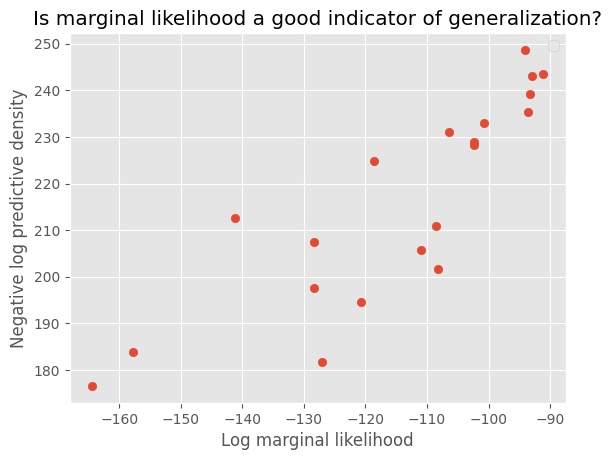

In [ ]:
trials_array = np.array(clml_trials)
clml_lpd = np.column_stack((trials_array[:, 2], trials_array[:, 1]))
scatterplot(clml_lpd)

In [ ]:
import importlib
import gp
importlib.reload(gp)
from gp import *
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [ ]:
X_seq, Y_seq = split_sequence(X_train, Y_train, seq_len=10)


# unconstrained_hyperparams=inverse_param_transform(hyperparams_inits[0])
# # clml_function = conditional_log_marginal_likelihood(cov_func, X_con, Y_con)
# # aaa=clml_function(unconstrained_hyperparams)

# clmls_function = conditional_log_marginal_likelihood_sequence(cov_func, X_seq, Y_seq)
# clml_vals=clmls_function(unconstrained_hyperparams)
# clml_vals


Array([-296.25440919, -276.05768386, -266.11471867, -276.46281244,
       -265.59780351, -258.37449375, -247.92072448, -253.47985996,
       -247.60031757], dtype=float64)

-283.06026816441545 4.646767064594063


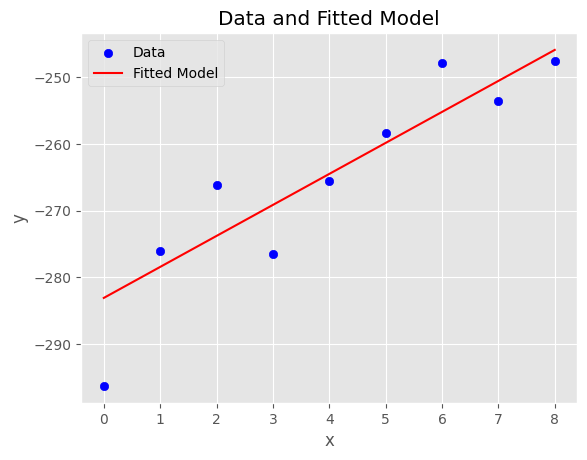

In [ ]:
# import importlib
# import gp
# importlib.reload(gp)
# from gp import *
# import matplotlib.pyplot as plt
# plt.style.use('ggplot')

# a,b =opt_clmls(clml_vals)
# print(a,b)
# x_data = np.arange(len(clml_vals))
# y_data = np.array(clml_vals)
# x_fit = np.linspace(min(x_data), max(x_data), 100)  # Smooth x range for the fitted curve
# y_fit = a + b * x_fit

# # Plot the data
# plt.scatter(x_data, y_data, color='blue', label='Data', zorder=5)

# # Plot the fitted model
# plt.plot(x_fit, y_fit, color='red', label='Fitted Model', zorder=4)

# # Add labels, legend, and title
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('Data and Fitted Model')
# plt.legend()


In [ ]:

import importlib
import gp
importlib.reload(gp)
from gp import *
import matplotlib.pyplot as plt
plt.style.use('ggplot')



# optimize hyperparameters according lml
clmls_trials = []
T=200
step_size = 5e-3
for n in range(n_trials):
   hyperparams_init = hyperparams_inits[n]
   unconstrained_hyperparams_init = inverse_param_transform(hyperparams_init)
   (unconstrained_hyperparams, clmls) = clmls_opt(cov_func, X_seq, Y_seq, unconstrained_hyperparams_init, step_size, T)
   hyperparams = param_transform(unconstrained_hyperparams)
   
   posterior_predictive = gp_posterior(cov_func, X_train, Y_train, hyperparams_init)
   (posterior_mean, posterior_var) = posterior_predictive(X_star)
   neg_log_initial = neg_log_predictive_density(Y_test, posterior_mean, posterior_var, hyperparams_init[0])

   posterior_predictive = gp_posterior(cov_func, X_train, Y_train, hyperparams)
   (posterior_mean, posterior_var) = posterior_predictive(X_star)
   neg_log_final = neg_log_predictive_density(Y_test, posterior_mean, posterior_var, hyperparams[0])
   print(np.array([neg_log_initial, neg_log_final, clmls]))
   clmls_trials.append(np.array([neg_log_initial, neg_log_final, clmls]))

0 -241.2393645830689
1 -225.0540002918469
2 -213.52621407710876
3 -205.6794392042334
4 -200.34749066543205
5 -196.44667308897507
6 -193.1236139050121
7 -189.7261322448711
8 -185.66119557013184
9 -180.2488239541571
10 -172.7813933771679
11 -163.15013049583746
12 -152.54852848208063
13 -142.60530445257214
14 -134.16688104029282
15 -127.21017035591584
16 -121.19988060315323
17 -115.43921479840797
18 -108.9944239129667
19 -100.17370600379746
20 -86.14068892832412
21 -66.62347275762248
22 -49.84812193641048
23 -37.832185234245486
24 -27.916157917981906
25 -19.232888908832834
26 -11.615823858531911
27 -5.277027880585109
28 -0.3249822014457209
29 3.4217635838167553
30 6.2471912917103225
31 8.405433569875953
32 10.091840922611226
33 11.44704893552975
34 12.568346061860808
35 13.521548278032327
36 14.350936797356326
37 15.086587502772545
38 15.749349781012967
39 16.354060315376728
40 16.91156465129501
41 17.429983230180937
42 17.9155151510175
43 18.372962635239674
44 18.806085653715115
45 19.21

KeyboardInterrupt: 

In [ ]:
trials_array = np.array(clmls_trials)
clmls_lpd = np.column_stack((trials_array[:, 2], trials_array[:, 1]))
scatterplot(clmls_lpd)